In [ ]:
#source: https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
#source: https://www.sciencedirect.com/science/article/pii/S0010482519303993?via%3Dihub

In [13]:
# Load in relevant libraries, and alias where appropriate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
import pandas as pd

df_821_path = r'C:\Users\rz200\Documents\Development\cell-SCT\classification\imported_CSV\dataframe_821'
data_path = df_821_path
df = pd.read_csv(df_821_path)

KeyboardInterrupt: 

In [172]:
array = np.zeros([100, 200, 4], dtype=np.uint8)
array[:,:100] = [255, 128, 0, 255] #Orange left side
array[:,100:] = [0, 0, 255, 255]   #Blue right side

# Set transparency depending on x position
for x in range(200):
    for y in range(100):
        array[y, x, 3] = x

print(array)

[[[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]

 [[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]

 [[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]

 ...

 [[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]

 [[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]

 [[255 128   0   0]
  [255 128   0   1]
  [255 128   0   2]
  ...
  [  0   0 255 197]
  [  0   0 255 198]
  [  0   0 255 199]]]


(22, 22)


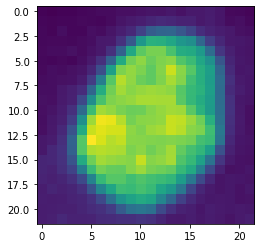

In [168]:
arr_dapi = str2array(df['dapi_crops'][0])*255
arr_cyclina2 = str2array(df['cyclina2_crops'][0])*255
arr_edu = str2array(df['edu_crops'][0])*255
arr_pcna = str2array(df['pcna_crops'][0])*255

no_img = 4
img = arr_dapi/no_img + arr_cyclina2/no_img + arr_edu/no_img + arr_pcna/no_img
print(img.shape)
plt.imshow(img)

(20, 20, 4)
RGBA (20, 20)


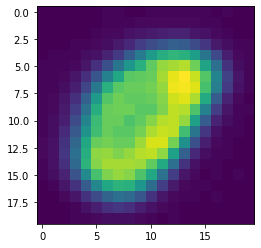

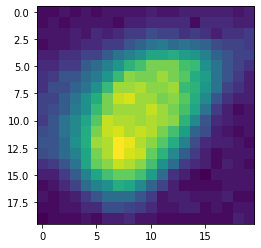

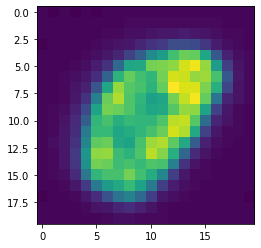

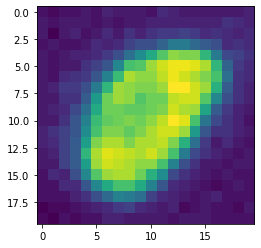

In [195]:
img_id = 1000
arr_dapi = str2array(df['dapi_crops'][img_id])*255
arr_cyclina2 = str2array(df['cyclina2_crops'][img_id])*255
arr_edu = str2array(df['edu_crops'][img_id])*255
arr_pcna = str2array(df['pcna_crops'][img_id])*255

arr = np.dstack((arr_dapi,arr_cyclina2,arr_edu,arr_pcna))
arr = arr.astype(np.uint8)
#arr = np.moveaxis(arr, -1, 0)
#print(arr)
print(arr.shape)

#plt.imshow(arr.T)
#im = Image.merge("RGB",(arr_dapi,arr_cyclina2,arr_edu))
im = Image.fromarray(arr)
print(im.mode, im.size)
#im = im.convert("L")
im.save('img_4_channels.png')
for i in range(4):
    plt.imshow(arr[...,i])
    plt.show()



In [202]:
from skimage import io

img_id = 1000
arr_dapi = str2array(df['dapi_crops'][img_id])*255
arr_cyclina2 = str2array(df['cyclina2_crops'][img_id])*255
arr_edu = str2array(df['edu_crops'][img_id])*255
arr_pcna = str2array(df['pcna_crops'][img_id])*255

arr = np.dstack((arr_dapi,arr_cyclina2,arr_edu,arr_pcna))
arr = arr.astype(np.uint8)

print(type(arr))

io.imread(arr)

<class 'numpy.ndarray'>


OSError: Cannot understand given URI: array([[[ 1, 26,  1, 34],
        [ 1, 26,  0, 33],
     ....

In [191]:
im=Image.open('img_4_channels.png')

In [203]:
plt.imshow(im[...,0])
print(im.mode, im.size)

TypeError: 'Image' object is not subscriptable

In [99]:
import shutil
from PIL import Image
import numpy as np
import os
from ccc_nn_functions import str2array

def sort_training_and_testing_data(df,test_size=0.2):
    shutil.rmtree('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\data')

    #create a new dataframe where we shuffle the rows
    df_shuffled = np.copy(df)
    df_shuffled = df.sample(frac=1).reset_index(drop=True) #we could keep the index to keep for the cell names so its consistent with the first dataframe, would hepl later on
    #df_shuffled = df[:10000]

    total_images = len(df)
    up_to = round((total_images-(total_images*test_size)))

    #create a new column in that dataframe called 'ground_truth'
    #for each row, if there is one True phase, that's the ground_truth
    #if there are no True phase or more than two, the ground_truth is 'unclassified' for now
    cycle_phase_encodings = []
    for i in range(len(df_shuffled['S_Phase'])):
        encoding_arr = []
        if df_shuffled['G1_Phase'][i]: encoding_arr.append('g1_phase')
        #else: encoding_arr.append(0)

        if df_shuffled['S_Phase'][i]: encoding_arr.append('s_phase')
        #else: encoding_arr.append(0)

        if df_shuffled['G2_M_Phase'][i]: encoding_arr.append('g2_m_phase')
        #else: encoding_arr.append(0)

        if len(encoding_arr) != 1: encoding_arr = ['unclassified']

        cycle_phase_encodings.append(encoding_arr)

    df_shuffled['ground_truth'] = cycle_phase_encodings

    #create a data directory
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data')

    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\g1_phase')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\s_phase')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\g2_m_phase')

    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\g1_phase')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\s_phase')
    os.mkdir('C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\g2_m_phase')

    #take the first 1-test_size (0.8) and put them in the train folders
    #create a training_data directory inside the data directory
    #create an s_phase, g1_phase and g2_m_phase directories in there
    #for each row in the first 0.8 of the dataframe, put the EdU numpy arrays in the corresponding folders
    #last_train_row = round(0,up_to)
    for i in range(0,up_to):
        if i % 1000 == 0: print(str(i+1) + '/' + str(up_to))
        name = 'cell_' + str(i)

        #print(str2array(df_shuffled['pcna_crops'][i])*255)

        try:
            arr = str2array(df_shuffled['pcna_crops'][i])*255
        except TypeError:
            pass

        if arr.dtype is np.dtype('object'):
            continue


        if df_shuffled['ground_truth'][i] == ['g1_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\g1_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

        elif df_shuffled['ground_truth'][i] == ['s_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\s_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

        elif df_shuffled['ground_truth'][i] == ['g2_m_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\training_data\\g2_m_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

    #do the same for the testing data
    for i in range(up_to,total_images):
        if i % 1000 == 0: print(str(i+1) + '/' + str(total_images))

        try:
            arr = str2array(df_shuffled['pcna_crops'][i])*255
        except TypeError:
            pass

        if arr.dtype is np.dtype('object'):
            continue

        name = 'cell_' + str(i)
        if df_shuffled['ground_truth'][i] == ['g1_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\g1_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

        elif df_shuffled['ground_truth'][i] == ['s_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\s_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

        elif df_shuffled['ground_truth'][i] == ['g2_m_phase']:
            path = 'C:\\Users\\rz200\\Documents\\development\\cell-SCT\\classification\\data\\testing_data\\g2_m_phase\\' + name + '.png'
            #arr = str2array(df_shuffled['pcna_crops'][i])
            im = Image.fromarray(arr)
            im = im.convert("L")
            im.save(path)

    #no need to return anything

sort_training_and_testing_data(df)

1/112027


C:\Users\rz200\Documents\development\cell-SCT\classification\ccc_nn_functions.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ast.literal_eval(s))


1001/112027
2001/112027
3001/112027
4001/112027
5001/112027
6001/112027
7001/112027
8001/112027
9001/112027
10001/112027
11001/112027
12001/112027
13001/112027
14001/112027
15001/112027
16001/112027
17001/112027
18001/112027
19001/112027
20001/112027
21001/112027
22001/112027
23001/112027
24001/112027
25001/112027
26001/112027
27001/112027
28001/112027
29001/112027
30001/112027
31001/112027
32001/112027
33001/112027
34001/112027
35001/112027
36001/112027
37001/112027
38001/112027
39001/112027
40001/112027
41001/112027
42001/112027
43001/112027
44001/112027
45001/112027
46001/112027
47001/112027
48001/112027
49001/112027
50001/112027
51001/112027
52001/112027
53001/112027
54001/112027
55001/112027
56001/112027
57001/112027
58001/112027
59001/112027
60001/112027
61001/112027
62001/112027
63001/112027
64001/112027
65001/112027
66001/112027
67001/112027
68001/112027
69001/112027
70001/112027
71001/112027
72001/112027
73001/112027
74001/112027
75001/112027
76001/112027
77001/112027
78001/11

In [278]:
import io
from torch.utils.data import Dataset


class CellImagesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        df = pd.read_csv(csv_file)
        indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if
                                           str2array(df['dapi_crops'][i]).dtype is np.dtype(
                                               'object')]  # skipping rows with shapes such as (7,)
        indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if
                                           str2array(df['cyclina2_crops'][i]).dtype is np.dtype(
                                               'object')]  # skipping rows with shapes such as (7,)
        indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if
                                           str2array(df['edu_crops'][i]).dtype is np.dtype(
                                               'object')]  # skipping rows with shapes such as (7,)
        indices_to_skip_img_wrong_shape = [i for i in range(len(df)) if
                                           str2array(df['pcna_crops'][i]).dtype is np.dtype(
                                               'object')]  # skipping rows with shapes such as (7,)
        df = df.drop(indices_to_skip_img_wrong_shape).reset_index(drop=True)

        cycle_phase_encodings = []
        for i in range(len(df['S_Phase'])):
            encoding_arr = []
            if df['G1_Phase'][i]: encoding_arr.append('g1_phase')
            #else: encoding_arr.append(0)

            if df['S_Phase'][i]: encoding_arr.append('s_phase')
            #else: encoding_arr.append(0)

            if df['G2_M_Phase'][i]: encoding_arr.append('g2_m_phase')
            #else: encoding_arr.append(0)

            if len(encoding_arr) != 1: encoding_arr = ['unclassified']

            cycle_phase_encodings.append(encoding_arr)

        df['ground_truth'] = cycle_phase_encodings


        self.cells_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cells_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #I want the image as 4 channels
        try:
            arr_dapi = str2array(df['dapi_crops'][idx])*255
            arr_cyclina2 = str2array(df['cyclina2_crops'][idx])*255
            arr_edu = str2array(df['edu_crops'][idx])*255
            arr_pcna = str2array(df['pcna_crops'][idx])*255
        except TypeError:
            pass

        arr = np.dstack((arr_dapi,arr_cyclina2,arr_edu,arr_pcna))
        image = arr.astype(np.uint8)

        #I want the label
        label = self.cells_frame['ground_truth'][idx][0]
        if label =='g1_phase':label=0
        elif label =='s_phase':label=1
        elif label=='g2_m_phase':label=2

        #I want to return them both as tensors
        #image = torch.from_numpy(image)
        #print(type(image))
        #label = torch.tensor(label)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        #image, label = sample['image'], sample['label']
        #image = torch.tensor(image)
        #sample = {'image': img, 'label': label}


        return sample

In [279]:
class CenterCrop(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = torchvision.transforms.CenterCrop(self.output_size).forward(image)
        return {'image': image, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': torch.tensor(label)}

In [281]:
transformed_dataset = CellImagesDataset(csv_file=r'C:\Users\rz200\Documents\development\cell-SCT\classification\imported_CSV\dataframe_821',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               CenterCrop(32),
                                               ToTensor()


                                           ]))

C:\Users\rz200\Documents\development\cell-SCT\classification\ccc_nn_functions.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(ast.literal_eval(s))


In [282]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['label'].size())

    if i == 3:
        break

TypeError: Unexpected type <class 'numpy.ndarray'>

In [ ]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i,sample['label'])

    if i == 1000:break

TypeError: Invalid shape (4, 32, 32) for image data

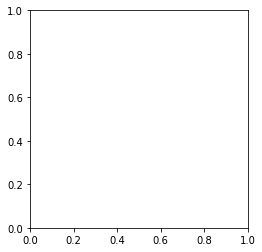

In [277]:
#plt.imshow(transformed_dataset[30]['image'])
#The images are all 0s, again

In [107]:
from torchvision import datasets,transforms

#datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

train_dataset = datasets.ImageFolder(root = r'C:\Users\rz200\Documents\development\cell-SCT\classification\data\training_data',
                                     transform = transforms.Compose([
                                         transforms.Grayscale(),
                                         transforms.Resize((32,32)),
                                         transforms.RandomRotation(degrees=(0,180)),
                                         transforms.ToTensor()]))

test_dataset = datasets.ImageFolder(root = r'C:\Users\rz200\Documents\development\cell-SCT\classification\data\testing_data',
                                          transform = transforms.Compose([
                                              transforms.Grayscale(),
                                              transforms.Resize((32,32)),
                                              transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

In [108]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [109]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [110]:
total_step = len(train_loader)
#should add a progress bar to this
losses = []
for epoch in range(num_epochs):
    losses_per_epoch = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0: print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (i+1) == total_step: print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        losses_per_epoch.append(loss.item())
    losses.append(sum(losses_per_epoch)/len(losses_per_epoch))

Epoch [1/10], Step [1/1599], Loss: 1.0549
Epoch [1/10], Step [101/1599], Loss: 0.7847
Epoch [1/10], Step [201/1599], Loss: 0.7740
Epoch [1/10], Step [301/1599], Loss: 0.7492
Epoch [1/10], Step [401/1599], Loss: 1.0579
Epoch [1/10], Step [501/1599], Loss: 0.9992
Epoch [1/10], Step [601/1599], Loss: 0.8333
Epoch [1/10], Step [701/1599], Loss: 0.5624
Epoch [1/10], Step [801/1599], Loss: 0.6702
Epoch [1/10], Step [901/1599], Loss: 0.8267
Epoch [1/10], Step [1001/1599], Loss: 0.8117
Epoch [1/10], Step [1101/1599], Loss: 0.7598
Epoch [1/10], Step [1201/1599], Loss: 0.6814
Epoch [1/10], Step [1301/1599], Loss: 0.7053
Epoch [1/10], Step [1401/1599], Loss: 0.8633
Epoch [1/10], Step [1501/1599], Loss: 0.8915
Epoch [1/10], Step [1599/1599], Loss: 0.7200
Epoch [2/10], Step [1/1599], Loss: 0.7781
Epoch [2/10], Step [101/1599], Loss: 0.7001
Epoch [2/10], Step [201/1599], Loss: 0.7558
Epoch [2/10], Step [301/1599], Loss: 0.7439
Epoch [2/10], Step [401/1599], Loss: 0.8187
Epoch [2/10], Step [501/1599]

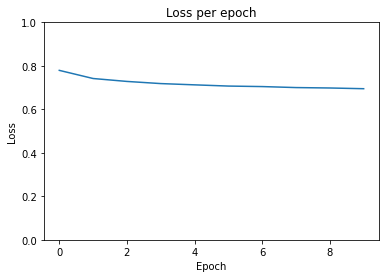

In [111]:
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.ylim([0,1])
plt.show()

In [112]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader), 100 * correct / total))


Accuracy of the network on the 400 test images: 65.25529752130737 %


In [ ]:
#I think the image are all 0s because they are normalised from 0 to 1
#At some point they get rounded (maybe when put as pngs) which makes them all 0s, so fully blank images
#We need to either not normalise them before we store them, or denormalise them by multiplying by 255
#This would explain why it was stuck at 67%? No since if it was random, it would be a 33% accuracy

#Need to add some augmentation